Import libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from math import sqrt
from transformers import TimeSeriesTransformerConfig, TimeSeriesTransformerModel
from gluonts.time_feature import get_lags_for_frequency, time_features_from_frequency_str

Load dataset and prepare df

In [12]:
import pandas as pd

# Load the dataset
file_path = '../data/owid-covid-data.csv'
df = pd.read_csv(file_path)

# We are interested in the 'new_deaths' column and the 'date' column which we will index by
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)



In [13]:
from gluonts.dataset.pandas import PandasDataset

ds = PandasDataset.from_long_dataframe(df, target="new_deaths", item_id="location")

In [ ]:
class ProcessStartField():
    ts_id = 0
    
    def __call__(self, data):
        data["start"] = data["start"].to_timestamp()
        data["feat_static_cat"] = [self.ts_id]
        self.ts_id += 1
        
        return data

In [14]:
from gluonts.itertools import Map

process_start = ProcessStartField()

list_ds = list(Map(process_start, ds))

AssertionError: Dataframe index is not uniformly spaced. If your dataframe contains data from multiple series in the same column ("long" format), consider constructing the dataset with `PandasDataset.from_long_dataframe` instead.

In [16]:
from datasets import Dataset, Features, Value, Sequence

features  = Features(
    {    
        "start": Value("timestamp[s]"),
        "target": Sequence(Value("float32")),
        "feat_static_cat": Sequence(Value("uint64")),
        # "feat_static_real":  Sequence(Value("float32")),
        # "feat_dynamic_real": Sequence(Sequence(Value("uint64"))),
        # "feat_dynamic_cat": Sequence(Sequence(Value("uint64"))),
        "item_id": Value("string"),
    }
)

In [ ]:
dataset = Dataset.from_list(list_ds, features=features)

In [3]:
from tsf import LocalTSF
builder = LocalTSF(name='covid_deaths_local')
builder.download_and_prepare()
dataset = builder.as_dataset(split="train")


/home/sambros/.local/lib/python3.8/site-packages/datasets/builder.py:342: FutureWarning: Parameter 'name' was renamed to 'config_name' in version 2.3.0 and will be removed in 3.0.0.
  warnings.warn(


Generating train split: 0 examples [00:00, ? examples/s]

DatasetGenerationError: An error occurred while generating the dataset

In [17]:
from datasets import load_dataset

dataset = load_dataset("monash_tsf", "covid_deaths")


In [18]:
train_example = dataset['train'][0]
train_example.keys()
print(train_example['start'])
print(train_example['target'])

2020-01-22 00:00:00
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 2.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 6.0, 6.0, 7.0, 7.0, 11.0, 14.0, 14.0, 15.0, 15.0, 18.0, 18.0, 21.0, 23.0, 25.0, 30.0, 30.0, 30.0, 33.0, 36.0, 36.0, 40.0, 42.0, 43.0, 47.0, 50.0, 57.0, 58.0, 60.0, 64.0, 68.0, 72.0, 85.0, 90.0, 95.0, 104.0, 106.0, 109.0, 115.0, 120.0, 122.0, 127.0, 132.0, 136.0, 153.0, 168.0, 169.0, 173.0, 178.0, 187.0, 193.0, 205.0, 216.0, 218.0, 219.0, 220.0, 227.0, 235.0, 246.0, 249.0, 257.0, 265.0, 270.0, 294.0, 300.0, 309.0, 327.0, 357.0, 369.0, 384.0, 405.0, 426.0, 446.0, 451.0, 471.0, 478.0, 491.0, 504.0, 546.0, 548.0, 569.0, 581.0]


In [19]:
freq = "D"
prediction_length = 30


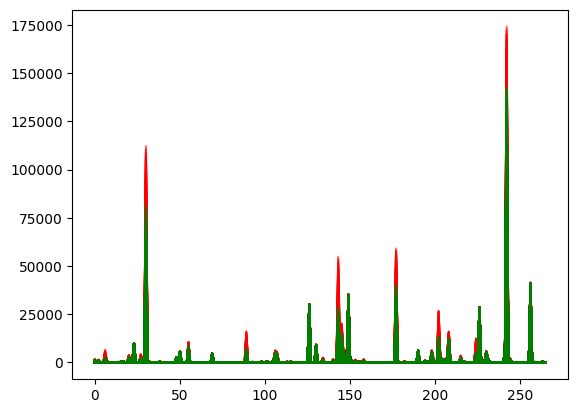

In [20]:
import matplotlib.pyplot as plt

figure, axes = plt.subplots()
axes.plot(dataset["train"]["target"], color="blue")
axes.plot(dataset["test"]["target"], color="red", alpha=0.5)
axes.plot(dataset["validation"]["target"], color="green", alpha=0.5)

plt.show()


In [21]:
train_dataset = dataset["train"]
test_dataset = dataset["test"]

In [22]:
from functools import lru_cache

import pandas as pd
import numpy as np

@lru_cache(10_000)
def convert_to_pandas_period(date, freq):
    return pd.Period(date, freq)

def transform_start_field(batch, freq):
    batch["start"] = [convert_to_pandas_period(date, freq) for date in batch["start"]]
    return batch


In [23]:
from functools import partial

train_dataset.set_transform(partial(transform_start_field, freq=freq))
test_dataset.set_transform(partial(transform_start_field, freq=freq))


In [24]:
from gluonts.time_feature import get_lags_for_frequency

lags_sequence = get_lags_for_frequency(freq)
print(lags_sequence)



[1, 2, 3, 4, 5, 6, 7, 8, 13, 14, 15, 20, 21, 22, 27, 28, 29, 30, 31, 56, 84, 363, 364, 365, 727, 728, 729, 1091, 1092, 1093]


In [25]:
from gluonts.time_feature import time_features_from_frequency_str

time_features = time_features_from_frequency_str(freq)
print(time_features)



[<function day_of_week at 0x7f87ba4eaf70>, <function day_of_month at 0x7f87b9fed0d0>, <function day_of_year at 0x7f87b9fed1f0>]


In [26]:
from transformers import TimeSeriesTransformerConfig, TimeSeriesTransformerForPrediction

config = TimeSeriesTransformerConfig(
    prediction_length=prediction_length,
    # context length:
    context_length=prediction_length * 2,
    # lags coming from helper given the freq:
    lags_sequence=lags_sequence,
    # we'll add 2 time features ("month of year" and "age", see further):
    num_time_features=len(time_features) + 1,
    # we have a single static categorical feature, namely time series ID:
    num_static_categorical_features=1,
    # it has 366 possible values:
    cardinality=[len(train_dataset)],
    # the model will learn an embedding of size 2 for each of the 366 possible values:
    embedding_dimension=[2],
    
    # transformer params:
    encoder_layers=4,
    decoder_layers=4,
    d_model=32,
)

model = TimeSeriesTransformerForPrediction(config)


In [27]:
from gluonts.time_feature import (
    time_features_from_frequency_str,
    TimeFeature,
    get_lags_for_frequency,
)
from gluonts.dataset.field_names import FieldName
from gluonts.transform import (
    AddAgeFeature,
    AddObservedValuesIndicator,
    AddTimeFeatures,
    AsNumpyArray,
    Chain,
    ExpectedNumInstanceSampler,
    InstanceSplitter,
    RemoveFields,
    SelectFields,
    SetField,
    TestSplitSampler,
    Transformation,
    ValidationSplitSampler,
    VstackFeatures,
    RenameFields,
)


In [28]:
from transformers import PretrainedConfig

def create_transformation(freq: str, config: PretrainedConfig) -> Transformation:
    remove_field_names = []
    if config.num_static_real_features == 0:
        remove_field_names.append(FieldName.FEAT_STATIC_REAL)
    if config.num_dynamic_real_features == 0:
        remove_field_names.append(FieldName.FEAT_DYNAMIC_REAL)
    if config.num_static_categorical_features == 0:
        remove_field_names.append(FieldName.FEAT_STATIC_CAT)

    # a bit like torchvision.transforms.Compose
    return Chain(
        # step 1: remove static/dynamic fields if not specified
        [RemoveFields(field_names=remove_field_names)]
        # step 2: convert the data to NumPy (potentially not needed)
        + (
            [
                AsNumpyArray(
                    field=FieldName.FEAT_STATIC_CAT,
                    expected_ndim=1,
                    dtype=int,
                )
            ]
            if config.num_static_categorical_features > 0
            else []
        )
        + (
            [
                AsNumpyArray(
                    field=FieldName.FEAT_STATIC_REAL,
                    expected_ndim=1,
                )
            ]
            if config.num_static_real_features > 0
            else []
        )
        + [
            AsNumpyArray(
                field=FieldName.TARGET,
                # we expect an extra dim for the multivariate case:
                expected_ndim=1 if config.input_size == 1 else 2,
            ),
            # step 3: handle the NaN's by filling in the target with zero
            # and return the mask (which is in the observed values)
            # true for observed values, false for nan's
            # the decoder uses this mask (no loss is incurred for unobserved values)
            # see loss_weights inside the xxxForPrediction model
            AddObservedValuesIndicator(
                target_field=FieldName.TARGET,
                output_field=FieldName.OBSERVED_VALUES,
            ),
            # step 4: add temporal features based on freq of the dataset
            # month of year in the case when freq="M"
            # these serve as positional encodings
            AddTimeFeatures(
                start_field=FieldName.START,
                target_field=FieldName.TARGET,
                output_field=FieldName.FEAT_TIME,
                time_features=time_features_from_frequency_str(freq),
                pred_length=config.prediction_length,
            ),
            # step 5: add another temporal feature (just a single number)
            # tells the model where in its life the value of the time series is,
            # sort of a running counter
            AddAgeFeature(
                target_field=FieldName.TARGET,
                output_field=FieldName.FEAT_AGE,
                pred_length=config.prediction_length,
                log_scale=True,
            ),
            # step 6: vertically stack all the temporal features into the key FEAT_TIME
            VstackFeatures(
                output_field=FieldName.FEAT_TIME,
                input_fields=[FieldName.FEAT_TIME, FieldName.FEAT_AGE]
                + (
                    [FieldName.FEAT_DYNAMIC_REAL]
                    if config.num_dynamic_real_features > 0
                    else []
                ),
            ),
            # step 7: rename to match HuggingFace names
            RenameFields(
                mapping={
                    FieldName.FEAT_STATIC_CAT: "static_categorical_features",
                    FieldName.FEAT_STATIC_REAL: "static_real_features",
                    FieldName.FEAT_TIME: "time_features",
                    FieldName.TARGET: "values",
                    FieldName.OBSERVED_VALUES: "observed_mask",
                }
            ),
        ]
    )


In [29]:
from gluonts.transform.sampler import InstanceSampler
from typing import Optional

def create_instance_splitter(
    config: PretrainedConfig,
    mode: str,
    train_sampler: Optional[InstanceSampler] = None,
    validation_sampler: Optional[InstanceSampler] = None,
) -> Transformation:
    assert mode in ["train", "validation", "test"]

    instance_sampler = {
        "train": train_sampler
        or ExpectedNumInstanceSampler(
            num_instances=1.0, min_future=config.prediction_length
        ),
        "validation": validation_sampler
        or ValidationSplitSampler(min_future=config.prediction_length),
        "test": TestSplitSampler(),
    }[mode]

    return InstanceSplitter(
        target_field="values",
        is_pad_field=FieldName.IS_PAD,
        start_field=FieldName.START,
        forecast_start_field=FieldName.FORECAST_START,
        instance_sampler=instance_sampler,
        past_length=config.context_length + max(config.lags_sequence),
        future_length=config.prediction_length,
        time_series_fields=["time_features", "observed_mask"],
    )


In [30]:
from typing import Iterable

import torch
from gluonts.itertools import Cached, Cyclic
from gluonts.dataset.loader import as_stacked_batches


def create_train_dataloader(
    config: PretrainedConfig,
    freq,
    data,
    batch_size: int,
    num_batches_per_epoch: int,
    shuffle_buffer_length: Optional[int] = None,
    cache_data: bool = True,
    **kwargs,
) -> Iterable:
    PREDICTION_INPUT_NAMES = [
        "past_time_features",
        "past_values",
        "past_observed_mask",
        "future_time_features",
    ]
    if config.num_static_categorical_features > 0:
        PREDICTION_INPUT_NAMES.append("static_categorical_features")

    if config.num_static_real_features > 0:
        PREDICTION_INPUT_NAMES.append("static_real_features")

    TRAINING_INPUT_NAMES = PREDICTION_INPUT_NAMES + [
        "future_values",
        "future_observed_mask",
    ]

    transformation = create_transformation(freq, config)
    transformed_data = transformation.apply(data, is_train=True)
    if cache_data:
        transformed_data = Cached(transformed_data)

    # we initialize a Training instance
    instance_splitter = create_instance_splitter(config, "train")

    # the instance splitter will sample a window of
    # context length + lags + prediction length (from the 366 possible transformed time series)
    # randomly from within the target time series and return an iterator.
    stream = Cyclic(transformed_data).stream()
    training_instances = instance_splitter.apply(
        stream, is_train=True
    )
    
    return as_stacked_batches(
        training_instances,
        batch_size=batch_size,
        shuffle_buffer_length=shuffle_buffer_length,
        field_names=TRAINING_INPUT_NAMES,
        output_type=torch.tensor,
        num_batches_per_epoch=num_batches_per_epoch,
    )


In [31]:
def create_test_dataloader(
    config: PretrainedConfig,
    freq,
    data,
    batch_size: int,
    **kwargs,
):
    PREDICTION_INPUT_NAMES = [
        "past_time_features",
        "past_values",
        "past_observed_mask",
        "future_time_features",
    ]
    if config.num_static_categorical_features > 0:
        PREDICTION_INPUT_NAMES.append("static_categorical_features")

    if config.num_static_real_features > 0:
        PREDICTION_INPUT_NAMES.append("static_real_features")

    transformation = create_transformation(freq, config)
    transformed_data = transformation.apply(data, is_train=False)

    # we create a Test Instance splitter which will sample the very last
    # context window seen during training only for the encoder.
    instance_sampler = create_instance_splitter(config, "test")

    # we apply the transformations in test mode
    testing_instances = instance_sampler.apply(transformed_data, is_train=False)
    
    return as_stacked_batches(
        testing_instances,
        batch_size=batch_size,
        output_type=torch.tensor,
        field_names=PREDICTION_INPUT_NAMES,
    )


In [32]:
train_dataloader = create_train_dataloader(
    config=config,
    freq=freq,
    data=train_dataset,
    batch_size=256,
    num_batches_per_epoch=100,
)

test_dataloader = create_test_dataloader(
    config=config,
    freq=freq,
    data=test_dataset,
    batch_size=64,
)


In [33]:
batch = next(iter(train_dataloader))
for k, v in batch.items():
    print(k, v.shape, v.type())

past_time_features torch.Size([256, 1153, 4]) torch.FloatTensor
past_values torch.Size([256, 1153]) torch.FloatTensor
past_observed_mask torch.Size([256, 1153]) torch.FloatTensor
future_time_features torch.Size([256, 30, 4]) torch.FloatTensor
static_categorical_features torch.Size([256, 1]) torch.LongTensor
future_values torch.Size([256, 30]) torch.FloatTensor
future_observed_mask torch.Size([256, 30]) torch.FloatTensor


In [34]:
# perform forward pass
outputs = model(
    past_values=batch["past_values"],
    past_time_features=batch["past_time_features"],
    past_observed_mask=batch["past_observed_mask"],
    static_categorical_features=batch["static_categorical_features"]
    if config.num_static_categorical_features > 0
    else None,
    static_real_features=batch["static_real_features"]
    if config.num_static_real_features > 0
    else None,
    future_values=batch["future_values"],
    future_time_features=batch["future_time_features"],
    future_observed_mask=batch["future_observed_mask"],
    output_hidden_states=True,
)


In [35]:
print("Loss:", outputs.loss.item())

Loss: 0.644978940486908


In [36]:
from accelerate import Accelerator
from torch.optim import AdamW

accelerator = Accelerator()
device = accelerator.device

model.to(device)
optimizer = AdamW(model.parameters(), lr=6e-4, betas=(0.9, 0.95), weight_decay=1e-1)

model, optimizer, train_dataloader = accelerator.prepare(
    model,
    optimizer,
    train_dataloader,
)

model.train()
for epoch in range(40):
    for idx, batch in enumerate(train_dataloader):
        optimizer.zero_grad()
        outputs = model(
            static_categorical_features=batch["static_categorical_features"].to(device)
            if config.num_static_categorical_features > 0
            else None,
            static_real_features=batch["static_real_features"].to(device)
            if config.num_static_real_features > 0
            else None,
            past_time_features=batch["past_time_features"].to(device),
            past_values=batch["past_values"].to(device),
            future_time_features=batch["future_time_features"].to(device),
            future_values=batch["future_values"].to(device),
            past_observed_mask=batch["past_observed_mask"].to(device),
            future_observed_mask=batch["future_observed_mask"].to(device),
        )
        loss = outputs.loss

        # Backpropagation
        accelerator.backward(loss)
        optimizer.step()

        if idx % 100 == 0:
            print(loss.item())


/home/sambros/.local/lib/python3.8/site-packages/torch/cuda/__init__.py:138: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11060). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


1.7411410808563232
-1.9440330266952515
-3.4127626419067383
-2.1942026615142822
-0.4502260982990265
-4.06198787689209
-2.680867910385132
-2.1419475078582764
-5.4429030418396
-6.694821357727051
-5.995903491973877
-3.914771795272827
-6.473811626434326
-5.753790378570557
-5.658921718597412
-5.165656566619873
-5.268820762634277
-5.426653861999512
-6.662775993347168
-4.441492080688477
-5.468269348144531
-5.764099597930908
-7.18928337097168
-5.966413497924805
-6.842861652374268
-7.7848286628723145
-6.356529712677002
-5.833433151245117
-4.108173370361328
-1.8301951885223389
-8.656574249267578
-5.4123854637146
-6.107641220092773
-5.752835273742676
-4.938060283660889
-5.763869762420654
-5.828458309173584
-3.56795334815979
-6.000949382781982
-5.0968241691589355


In [37]:
model.eval()

forecasts = []

for batch in test_dataloader:
    outputs = model.generate(
        static_categorical_features=batch["static_categorical_features"].to(device)
        if config.num_static_categorical_features > 0
        else None,
        static_real_features=batch["static_real_features"].to(device)
        if config.num_static_real_features > 0
        else None,
        past_time_features=batch["past_time_features"].to(device),
        past_values=batch["past_values"].to(device),
        future_time_features=batch["future_time_features"].to(device),
        past_observed_mask=batch["past_observed_mask"].to(device),
    )
    forecasts.append(outputs.sequences.cpu().numpy())


In [38]:
forecasts[0].shape

(64, 100, 30)

In [39]:
forecasts = np.vstack(forecasts)
print(forecasts.shape)

(266, 100, 30)


In [58]:
from evaluate import load
from gluonts.time_feature import get_seasonality
import math
mase_metric = load("evaluate-metric/mase")
smape_metric = load("evaluate-metric/smape")
mse_metric = load("evaluate-metric/mse")

forecast_median = np.median(forecasts, 1)

mase_metrics = []
smape_metrics = []
mse_metrics = []
for item_id, ts in enumerate(test_dataset):
    training_data = ts["target"][:-prediction_length]
    ground_truth = ts["target"][-prediction_length:]
    mase = mase_metric.compute(
        predictions=forecast_median[item_id], 
        references=np.array(ground_truth), 
        training=np.array(training_data), 
        periodicity=get_seasonality(freq))
    mase_metrics.append(mase["mase"])
    
    smape = smape_metric.compute(
        predictions=forecast_median[item_id], 
        references=np.array(ground_truth), 
    )
    smape_metrics.append(smape["smape"])
    
    mse = mse_metric.compute(
        predictions=forecast_median[item_id], 
        references=np.array(ground_truth), 
    )
    mse_metrics.append(math.sqrt(mse["mse"]))


In [41]:
print(f"MASE: {np.mean(mase_metrics)}")

MASE: 404338708427265.3


In [42]:
print(f"sMAPE: {np.mean(smape_metrics)}")

sMAPE: 0.4581626544166496


In [59]:
print(f"MSE: {np.mean(mse_metrics)}")

MSEE: 735.7486505397948


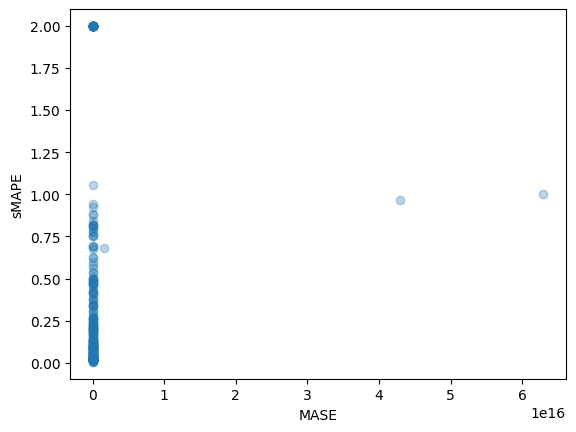

In [43]:
plt.scatter(mase_metrics, smape_metrics, alpha=0.3)
plt.xlabel("MASE")
plt.ylabel("sMAPE")
plt.show()

In [44]:
import matplotlib.dates as mdates

def plot(ts_index):
    fig, ax = plt.subplots()

    index = pd.period_range(
        start=test_dataset[ts_index][FieldName.START],
        periods=len(test_dataset[ts_index][FieldName.TARGET]),
        freq=freq,
    ).to_timestamp()

    # Major ticks every half year, minor ticks every month,
    ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 7)))
    ax.xaxis.set_minor_locator(mdates.MonthLocator())

    ax.plot(
        index[-2*prediction_length:], 
        test_dataset[ts_index]["target"][-2*prediction_length:],
        label="actual",
    )

    plt.plot(
        index[-prediction_length:], 
        np.median(forecasts[ts_index], axis=0),
        label="median",
    )
    
    plt.fill_between(
        index[-prediction_length:],
        forecasts[ts_index].mean(0) - forecasts[ts_index].std(axis=0), 
        forecasts[ts_index].mean(0) + forecasts[ts_index].std(axis=0), 
        alpha=0.3, 
        interpolate=True,
        label="+/- 1-std",
    )
    plt.legend()
    plt.show()


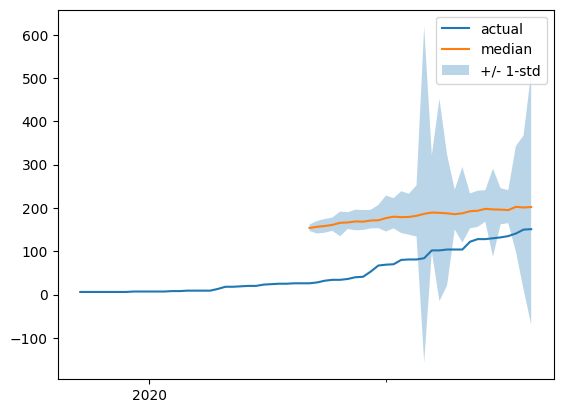

In [47]:
plot(265)


In [48]:
forecasts

array([[[1519.5969 , 1632.8063 , 1466.6958 , ..., 1689.9677 ,
         1812.6282 , 1681.504  ],
        [1504.2382 , 1496.2163 , 1700.7568 , ..., 1813.1359 ,
         1779.8695 , 1730.6593 ],
        [1700.9604 , 1624.9954 , 1712.9827 , ..., 1998.5756 ,
         2065.595  , 2004.2072 ],
        ...,
        [1476.3678 , 1388.301  , 1509.7821 , ..., 1710.5687 ,
         1792.842  , 1719.6652 ],
        [1514.3524 , 1554.1617 , 1573.2281 , ..., 1712.1381 ,
         1647.1641 , 1727.5901 ],
        [1328.6299 , 1445.4639 , 1571.8448 , ..., 1793.7759 ,
         1748.6392 , 1737.5039 ]],

       [[ 234.54175,  190.14333,  229.79268, ...,  236.01688,
          236.03984,  242.52492],
        [ 221.05643,  230.96207,  203.73254, ...,  255.30719,
          266.9561 ,  255.35056],
        [ 231.15427,  218.78606,  272.01044, ...,  259.83124,
          250.17795,  209.37624],
        ...,
        [ 229.37598, -533.6961 ,  166.4766 , ...,  283.8402 ,
          292.6467 ,  250.72713],
        [ 23